---
tags:
- pytorch
- DL

include:
- math
---

# 搭建模型

在pytorch搭建各种各样的神经网络是非常方便的，我感觉这也是pytorch在科研圈大热的原因之一。

## torch.nn

torch.nn就是torch中用来搭建神经网络（Neural Network）的模块。它包含以下内容：

- Containers
    - 例如`nn.Module`和`nn.Sequential`
- Convolution Layers
    - 例如`nn.Conv2d`
- Pooling layers
    - 例如`nn.MaxPool2d`
- Padding Layers
    - 例如`nn.ZeroPad2d`
- Non-linear Activations (weighted sum, nonlinearity)
    - 例如`nn.ReLU`
- Non-linear Activations (other)
    - 例如`nn.Softmax`
- Normalization Layers
    - 例如`nn.BatchNorm2d`
- Recurrent Layers
    - 例如`nn.RNN`和`nn.LSTM`
- Transformer Layers
    - 例如`nn.Transformer`
- Linear Layers
    - 例如`nn.Linear`
- Dropout Layers
    - 例如`nn.Dropout`
- Sparse Layers
    - 例如`nn.Embedding`
- Distance Functions
    - 例如`nn.CosineSimilarity`
- Loss Functions
    - 例如`nn.MSELoss`
- Vision Layers
    - 例如`nn.PixelShuffle`
- Shuffle Layers
    - 例如`nn.ChannelShuffle`
- DataParallel Layers (multi-GPU, distributed)
    - `nn.DataParallel`和`nn.parallel.DistributedDataParallel`
- Utilities
    - 例如`nn.Flatten`


用这些模块可以搭建出各种各样的神经网络。

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(0)

## 模型发展简史

深度学习发展至今，模型结构已经演化地错综复杂。网上找了一张神经网络发展的脉络图：

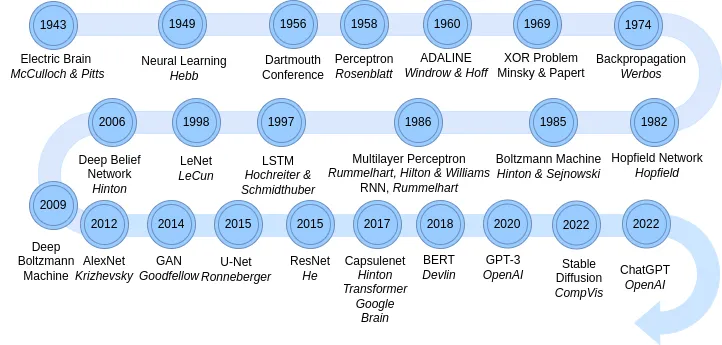

> 图源：[A Brief History of Neural Nets](https://pub.towardsai.net/a-brief-history-of-neural-nets-472107bc2c9c)

这张基本囊括了今天要介绍的模型。

## 感知器

1958由Rosenblatt提出的[感知器](https://psycnet.apa.org/record/1959-09865-001)（Perceptron）应该是最早的ANN（artificial neural network）了。

它本质上就是一个二维平面的线性分类器：

$$
y = f(x) = \frac{w^Tx+\epsilon}{|w^Tx+\epsilon|}
$$

根据$w^Tx$的符号来输出分类结果。

In [2]:
class Perceptron(nn.Module):
    """
    Perceptron.

    Rosenblatt, F. (1958). The perceptron: a probabilistic model for information storage and organization in the brain. Psychological review, 65(6), 386.
    """

    def __init__(self, input_size, output_size=1, episilon=1e-6):
        super(Perceptron, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.episolon = episilon

    def forward(self, x):
        t = self.linear(x)
        return (t + self.episolon) / torch.abs(t + self.episolon)

In [3]:
x = torch.randn(3)
p = Perceptron(3)
p(x)

tensor([1.], grad_fn=<DivBackward0>)

## 多层感知器

感知器有一个很大的问题：他是线性的，无法处理非线性问题，1969年发表的《Perceptrons: An Introduction to Computational Geometry》一书中就提出了[XOR函数的拟合问题](https://en.wikipedia.org/wiki/Perceptrons_(book))。

自然地，人们就开始扩展感知器，得到了多层感知器（MLP）。不过这种模型比较复杂，难以训练。直到1986年，Hinton他们发表了文章，使用反向传播算法求解MLP，MLP才真正可用。

> 当然，反向传播算法并非Hinton他们发明的，而是1974年[Pail Werbos](https://en.wikipedia.org/wiki/Paul_Werbos)发明。

这时候MLP的结构已经很现代化了：


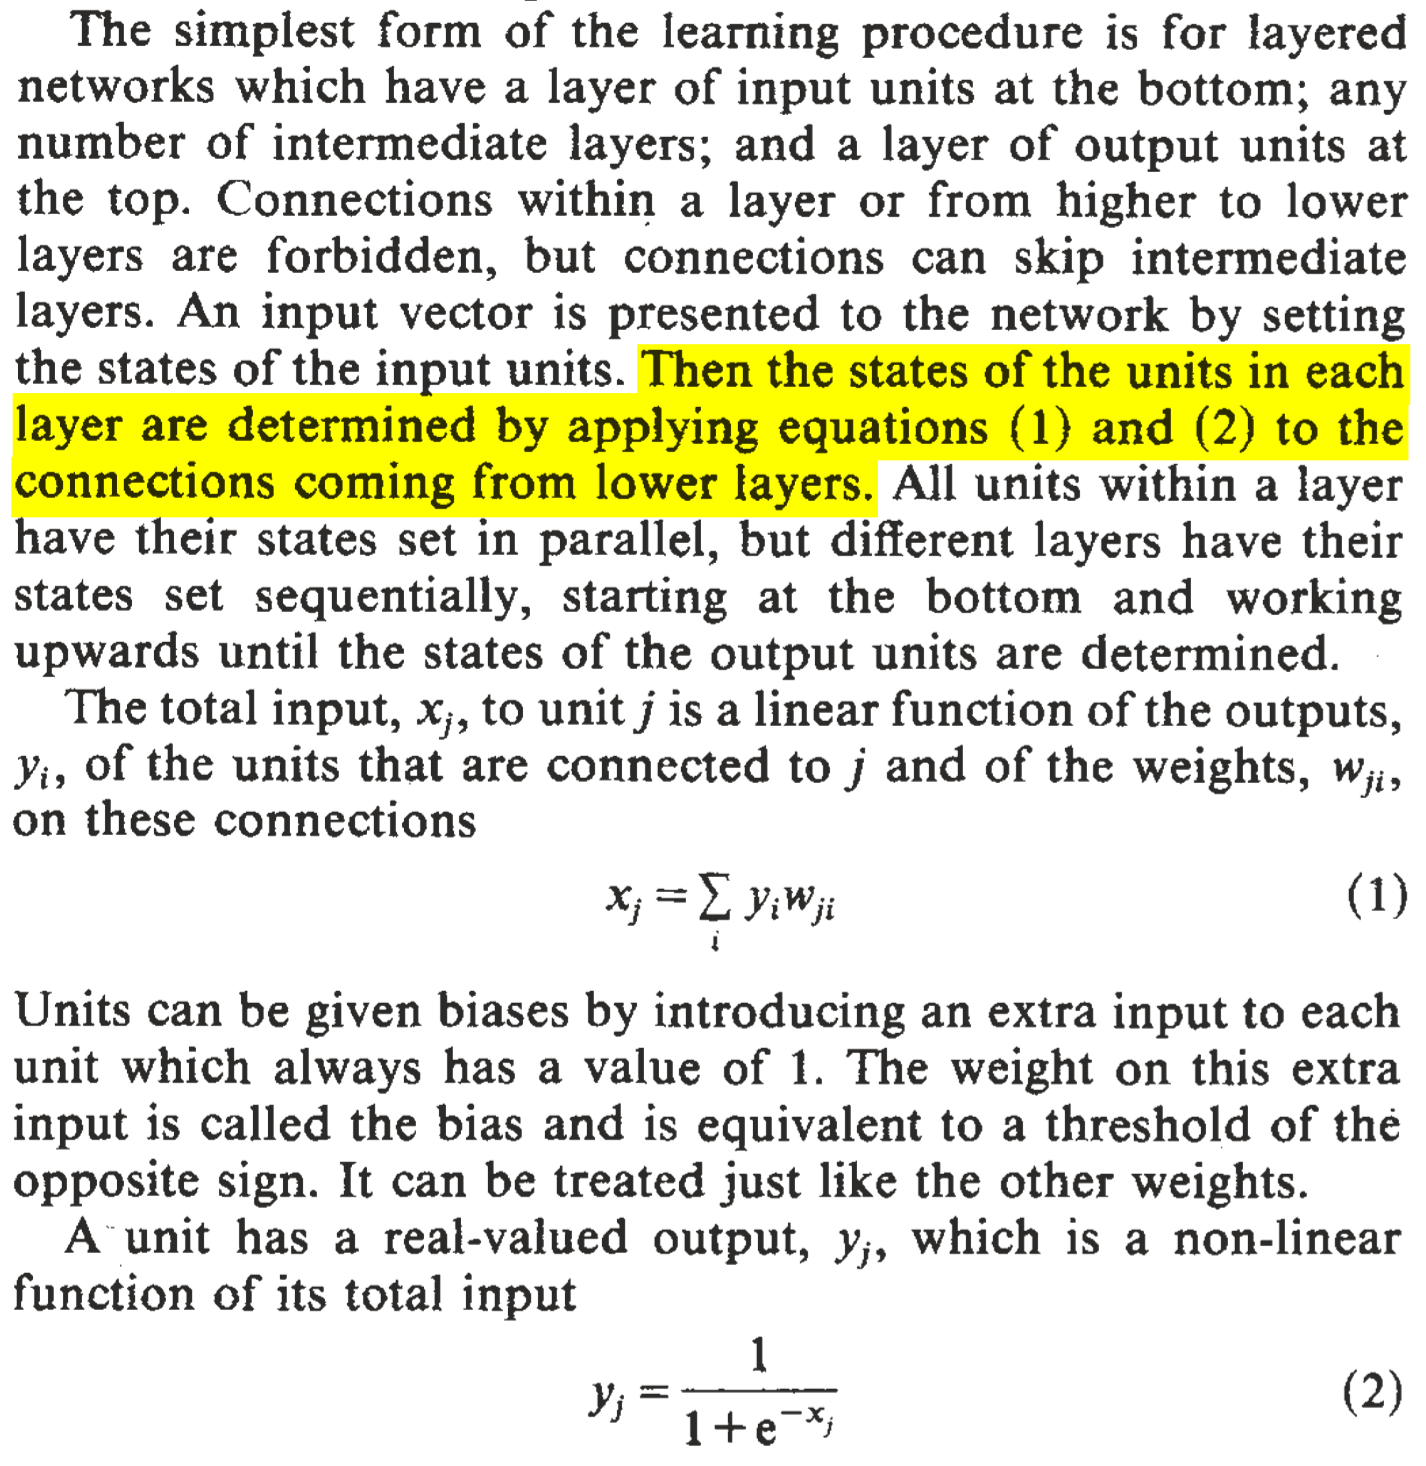

也就是我们现在说的线性函数+激活函数的架构了：

$$
y = (a_2 \circ h_2 \circ a_1 \circ h_1) (x)
$$

其中$a_1,a_2$是激活函数，$h1,h2$是隐藏层的线性函数

In [4]:
class MLP(nn.Module):
    """
    Multilayer Perceptron.
    
    Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning representations by back-propagating errors. nature, 323(6088), 533-536.
    """

    def __init__(self, input_size, hidden_size, output_size=1):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        x = torch.sigmoid(self.output(x))
        return x

In [5]:
# training data
X = torch.Tensor([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = torch.Tensor([0, 1, 1, 0]).view(-1, 1)
X.shape, Y.shape

(torch.Size([4, 2]), torch.Size([4, 1]))

In [6]:
mlp = MLP(2, 5, 1)
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.1)
log = []
for epoch in range(200):
    total_loss = 0
    pred = mlp(X)
    loss = loss_func(pred, Y)
    mlp.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    log.append(total_loss / 4)

经过反向传播训练，我们的MLP已经可以完美复现XOR函数了

In [7]:
mlp(torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]]).float()) > 0.5, Y

(tensor([[False],
         [ True],
         [ True],
         [False]]),
 tensor([[0.],
         [1.],
         [1.],
         [0.]]))

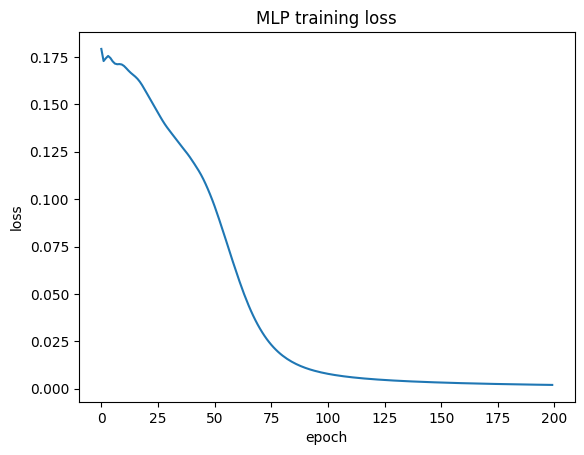

In [8]:
plt.plot(log)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('MLP training loss')
plt.show()

## 循环神经网络

循环神经网络（Recurrent neural network, RNN）也是在1986年提出的，他和MLP的主要区别在于：前者是一种**前馈神经网络**（Feedforward neural network, FFNN或者FNN），网络中不存在反馈（Feedback）和回环（Recurrent
）。通俗来说就是$y=f(x)$的计算过程中信息只会向前传递。

而RNN是为了序列数据而生的，它的设计理念很简单：建模序列数据之前的（一阶或者更高阶）相关性。

隐藏层的计算从：
$$
h = \sigma (Wx+b)
$$
变为（Elman network）
$$
h_t = \sigma (Wx_t+b+U{\color{red}h_{t-1}}+c)
$$

当然也有其他设计（Jordan network），引入一个额外中间变量$s_t$（state）：
$$
\begin{aligned}
&h_t = \sigma (W_1x_t+b_1+U_1s_{t}+c_1)\\
&s_t = \sigma (W_2s_{t-1}+b_2+W_3y_{t-1}+b_3)
\end{aligned}
$$

最终都输出：
$$
y_t = \sigma(W_y h_t + b_y)
$$

### 朴素实现

In [9]:
class ElmanRNN(nn.Module):
    """
    Elman RNN.

    Elman, J. L. (1990). Finding structure in time. Cognitive science, 14(2), 179-211.
    """

    def __init__(self, input_size, hidden_size, output_size=1):
        super(ElmanRNN, self).__init__()
        self.linear_x = nn.Linear(input_size, hidden_size)
        self.linear_h = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state=None):
        if hidden_state is None:
            # 初始化隐藏状态为零
            hidden_state = torch.zeros(x.size(0), self.linear_h.out_features)
        hidden_state = torch.tanh(self.linear_x(x) + self.linear_h(hidden_state))
        return torch.sigmoid(self.output(hidden_state)), hidden_state

In [10]:
rnn = ElmanRNN(3, 2, 1)

x = torch.randn(2, 3)
rnn(x)

(tensor([[0.5761],
         [0.5446]], grad_fn=<SigmoidBackward0>),
 tensor([[ 0.4800, -0.4256],
         [ 0.5130,  0.0264]], grad_fn=<TanhBackward0>))

### torch.nn.RNNCell

当然，RNN层在`torch.nn`中已经有了实现
```python
hidden_state = torch.tanh(self.linear_x(x) + self.linear_h(hidden_state))
```
可以替换为：
```python
hidden_state = nn.RNNCell(3,2)(x, hidden_state)
```

In [11]:
rnn_cell = nn.RNNCell(3, 2)

In [12]:
# 由于浮点精度误差的存在，我们这里不使用torch.equal来判断两个tensor是否相等
# 而是使用torch.allclose来判断两个tensor是否在一定的精度范围内相等


torch.allclose(
    # torch封装的RNNCell
    rnn_cell(x, torch.ones(2, 2)),
    # 手动计算矩阵乘法和激活函数
    torch.tanh(
        x @ rnn_cell.weight_ih.T
        + torch.ones(2, 2) @ rnn_cell.weight_hh.T
        + rnn_cell.bias_hh
        + rnn_cell.bias_ih
    ),
)

True

可以看到我们手动计算的结果和torch的实现是一致的。

### torch.nn.RNN

上面的RNNCell只是单个时间步的计算。并且只有一层

一般情况RNN不会只有一层。所以我们通常需要构造多层的RNN。这时可以使用torch的封装：`torch.nn.RNN`

![](https://d2l.ai/_images/deep-rnn.svg)

In [13]:
input_size, hidden_size, num_layers = 3, 5, 2
rnn = nn.RNN(input_size, hidden_size, num_layers)
params = dict(rnn.named_parameters())
x = torch.randn(2, 4, 3)

我们可以打印出多层RNN的所有参数，可以清晰地看到所有：

In [14]:
for name, param in rnn.named_parameters():
    print(name, param.shape, sep=', ')

weight_ih_l0, torch.Size([5, 3])
weight_hh_l0, torch.Size([5, 5])
bias_ih_l0, torch.Size([5])
bias_hh_l0, torch.Size([5])
weight_ih_l1, torch.Size([5, 5])
weight_hh_l1, torch.Size([5, 5])
bias_ih_l1, torch.Size([5])
bias_hh_l1, torch.Size([5])


我们再用矩阵计算手撕一个RNN：

> 坑爹的是：torch官方文档里写的计算过程是错的😭，我特地提了一个[pr](https://github.com/pytorch/pytorch/pull/153620)

In [15]:
def forward(x, hx=None, batch_first=False):
    if batch_first:
        x = x.transpose(0, 1)
    seq_len, batch_size, _ = x.size()
    if hx is None:
        hx = torch.zeros(rnn.num_layers, batch_size, rnn.hidden_size)
    h_t_minus_1 = hx.clone()
    h_t = hx.clone()
    output = []
    for t in range(seq_len):
        for layer in range(rnn.num_layers):
            input_t = x[t] if layer == 0 else h_t[layer - 1]
            h_t[layer] = torch.tanh(
                input_t @ params[f"weight_ih_l{layer}"].T
                + h_t_minus_1[layer] @ params[f"weight_hh_l{layer}"].T
                + params[f"bias_hh_l{layer}"]
                + params[f"bias_ih_l{layer}"]
            )
        output.append(h_t[-1].clone())
        h_t_minus_1 = h_t.clone()
    output = torch.stack(output)
    if batch_first:
        output = output.transpose(0, 1)
    return output, h_t

In [16]:
official_imp = rnn(x)
my_imp = forward(x)

# 由于浮点精度误差的存在，我们这里不使用torch.equal来判断两个tensor是否相等
assert torch.allclose(official_imp[0], my_imp[0])
assert torch.allclose(official_imp[1], my_imp[1])

In [17]:
official_imp[0], my_imp[0]

(tensor([[[ 0.0240,  0.0873,  0.3947, -0.1823,  0.2245],
          [ 0.1614,  0.3477,  0.2290, -0.4516,  0.3728],
          [ 0.0630, -0.0855,  0.2558,  0.0493,  0.3497],
          [-0.2968, -0.1529,  0.5566,  0.2263,  0.1118]],
 
         [[-0.4239, -0.1121,  0.4294,  0.1061,  0.3151],
          [-0.5511,  0.0827,  0.4707, -0.2208,  0.2897],
          [-0.1216,  0.2675,  0.2731, -0.2461,  0.4034],
          [ 0.3489, -0.0636,  0.1067, -0.1008,  0.5025]]],
        grad_fn=<StackBackward0>),
 tensor([[[ 0.0240,  0.0873,  0.3947, -0.1823,  0.2245],
          [ 0.1614,  0.3477,  0.2290, -0.4516,  0.3728],
          [ 0.0630, -0.0855,  0.2558,  0.0493,  0.3497],
          [-0.2968, -0.1529,  0.5566,  0.2263,  0.1118]],
 
         [[-0.4239, -0.1121,  0.4294,  0.1061,  0.3151],
          [-0.5511,  0.0827,  0.4707, -0.2208,  0.2897],
          [-0.1216,  0.2675,  0.2731, -0.2461,  0.4034],
          [ 0.3489, -0.0636,  0.1067, -0.1008,  0.5025]]],
        grad_fn=<StackBackward0>))

可以看到，我们手动计算的结果和torch封装的结果完全一致！

### LSTM

RNN存在诸多问题，为此后续还有诸多的改进版。包括GRU，LSTM等。

这里就不展开了

## 卷积神经网络

卷积神经网络（convolutional neural network, CNN）的思想最早1979年就被日本学者[福島邦彦](https://en.wikipedia.org/wiki/Kunihiko_Fukushima)提出了。后来LeCun在1998年提出了LeNet，就基本是现代CNN的形状了。

CNN是为了图像数据而生，它和MLP最大的区别在于前者是部分连接的网络，而后者是全连接神经网络（Fully Convolutional Neural Network, FCNN）。这一区别来自CNN最核心的算子：**卷积**。

在卷积操作下，神经网络层与层之间的连接不再是稠密的：后一层的任何一点都与前一层的所有点相关；而变地稀疏：后一层的点只与前一层的部分区域相关，这个区域大小就是感受野。

> 卷积可视化，图源：<https://github.com/vdumoulin/conv_arithmetic>

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/arbitrary_padding_no_strides.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides（普通卷积）</td>
    <td>Padding=2, no strides（外围填充）</td>
  </tr>
  <tr>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_strides.gif"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/dilation.gif"></td>
  </tr>
  <tr>
    <td>No padding, strides=2（步长为2）</td>
    <td>No padding, no stride, dilation=1（空洞卷积）</td>
  </tr>
</table>

当然，卷积这个操作并非计算机领域的独创。数学上的卷积早已广泛应用于信号处理、图像处理、概率、微分方程等领域。

例如信号处理领域，卷积操作经常用来做滤波，例如高通滤波、低通滤波。类似的，在图像处理领域卷积操作也可以作为一种滤波器，例如sobel算子就是常用的边缘检测算子（提取高频信号）。

### 卷积

在torch中实现CNN也是比较简单的，有封装好的`torch.nn.Conv2d`可以用

In [18]:
conv = nn.Conv2d(
    in_channels=3,  # 输入通道数
    out_channels=2, # 输出通道数
    kernel_size=3,  # 卷积核大小
    stride=1,       # 步长
    padding=0,      # 填充
    dilation=1,     # 扩张（空洞卷积）
    groups=1,       # 分组卷积
    bias=True,      # 是否使用偏置
    padding_mode='zeros',  # 填充模式
    device=None,    # 设备
    dtype=None,     # 数据类型
)
x = torch.randn(1, 3, 5, 5)  # BCHW
conv(x).shape, x.shape

(torch.Size([1, 2, 3, 3]), torch.Size([1, 3, 5, 5]))

In [19]:
params = dict(conv.named_parameters())
for p in params:
    print(p, params[p].shape, sep=', ')

weight, torch.Size([2, 3, 3, 3])
bias, torch.Size([2])


我们用矩阵运算来复现一下卷积的计算过程。这里面的计算实在太多，我们只算两个值：

In [20]:
conv(x)

tensor([[[[-0.0524,  0.4434, -0.2698],
          [-0.0481,  0.1081, -0.8976],
          [-0.6165, -1.1109,  0.0183]],

         [[ 0.2764,  0.2990, -0.2355],
          [-0.7854, -0.3800, -0.3721],
          [-1.3321, -0.5189,  0.1417]]]], grad_fn=<ConvolutionBackward0>)

In [21]:
# conv(x)[0, 0, 0, 0] 第一通道，第一个像素点
c1 = (x[0, 0, 0:3, 0:3] * conv.weight[0, 0, ...]).sum() # 第一个通道进行卷积
c2 = (x[0, 1, 0:3, 0:3] * conv.weight[0, 1, ...]).sum() # 第二个通道进行卷积
c3 = (x[0, 2, 0:3, 0:3] * conv.weight[0, 2, ...]).sum() # 第三个通道进行卷积
c1 + c2 + c3 + conv.bias[0], conv(x)[0, 0, 0, 0]

(tensor(-0.0524, grad_fn=<AddBackward0>),
 tensor(-0.0524, grad_fn=<SelectBackward0>))

In [22]:
# conv(x)[0, 1, 0, 1] 第二通道，第四个像素点
c1 = (x[0, 0, 1:4, 1:4] * conv.weight[1, 0, ...]).sum() # 第一个通道进行卷积
c2 = (x[0, 1, 1:4, 1:4] * conv.weight[1, 1, ...]).sum() # 第二个通道进行卷积
c3 = (x[0, 2, 1:4, 1:4] * conv.weight[1, 2, ...]).sum() # 第三个通道进行卷积
c1 + c2 + c3 + conv.bias[1], conv(x)[0, 1, 1, 1]

(tensor(-0.3800, grad_fn=<AddBackward0>),
 tensor(-0.3800, grad_fn=<SelectBackward0>))

最后我们给出卷积操作的维度变化：

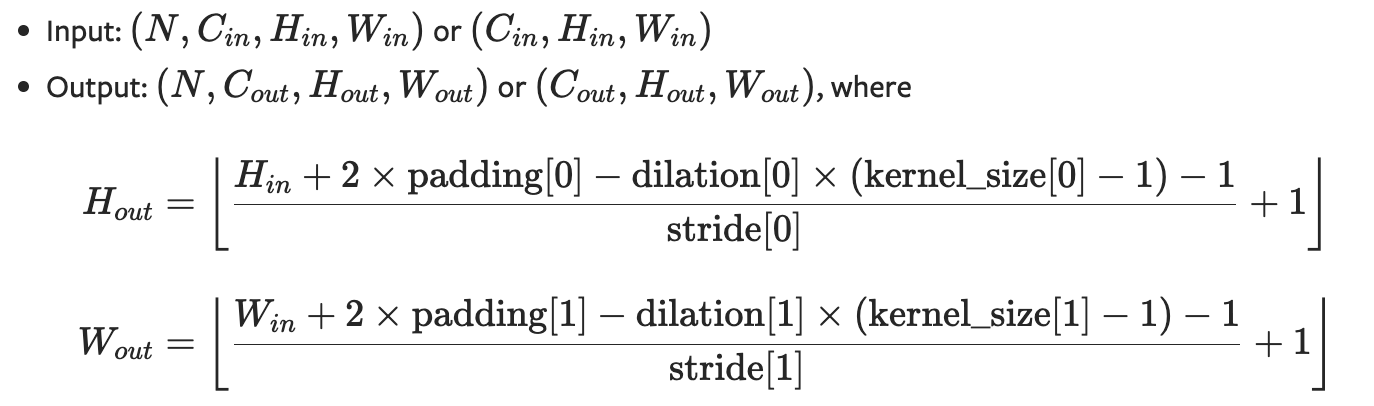

### LeNet
LeNet是最经典的CNN了，它的结构也很简单

In [23]:
class LeNet(nn.Module):
    """
    LeNet.

    LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324.
    """

    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        x = torch.tanh(self.conv2(x))
        x = nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
lenet = LeNet()

用torchsummary可以看到tensor在网络中的尺寸变化

In [25]:
from torchsummary import summary
_ = summary(lenet, (1, 28, 28), verbose=2)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 28, 28]           156
├─Conv2d: 1-2                            [-1, 16, 10, 10]          2,416
├─Linear: 1-3                            [-1, 120]                 48,120
├─Linear: 1-4                            [-1, 84]                  10,164
├─Linear: 1-5                            [-1, 10]                  850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29


### AlexNet

代码来自: <https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py>

In [26]:
class AlexNet(nn.Module):
    """
    AlexNet.

    Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. Advances in neural information processing systems, 25.
    """
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

AlexNet 是第一个把深度CNN带火了网络了。

### 转置卷积

我们知道，一般情况下卷积显然是一个下采样的算子（人话：经过卷积操作，图像变小了）。

当然，我们可以通过增大padding参数来增加输出结果的尺寸。或者和空洞卷积的想法类似给图像加上Dilation。

于是我们就有了上采样算子：转置卷积（也叫反卷积）。

> 转置卷积可视化，图源：<https://github.com/vdumoulin/conv_arithmetic>

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides_transposed.gif"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/arbitrary_padding_no_strides_transposed.gif"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/same_padding_no_strides_transposed.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides, transposed</td>
    <td>Arbitrary padding, no strides, transposed</td>
    <td>Half padding, no strides, transposed</td>
  </tr>
  <tr>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/no_padding_strides_transposed.gif"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_transposed.gif"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd_transposed.gif"></td>
  </tr>
  <tr>
    <td>No padding, strides, transposed</td>
    <td>Padding, strides, transposed</td>
    <td>Padding, strides, transposed (odd)</td>
  </tr>
</table>

In [27]:
deconv = nn.ConvTranspose2d(
    in_channels=1,        # 输入通道数
    out_channels=1,       # 输出通道数
    kernel_size=3,        # 卷积核大小
    stride=1,             # 步长
    padding=0,            # 填充
    output_padding=0,     # 输出填充
    dilation=1,           # 扩张（空洞卷积）
    groups=1,             # 分组卷积
    bias=True,            # 是否使用偏置
    padding_mode="zeros", # 填充模式
    device=None,          # 设备
    dtype=None,           # 数据类型
)

In [28]:
x = torch.randn(1, 1, 2, 2)  # BCHW
deconv(x).shape, x.shape

(torch.Size([1, 1, 4, 4]), torch.Size([1, 1, 2, 2]))

在数据维度上，转置卷积基本就是卷积的逆操作：
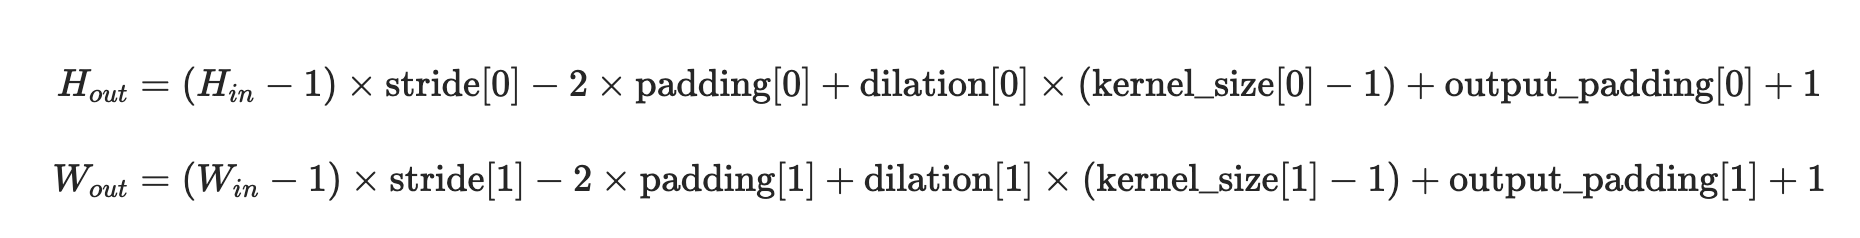

### U-Net

转置卷积有一个经典应用：U-Net

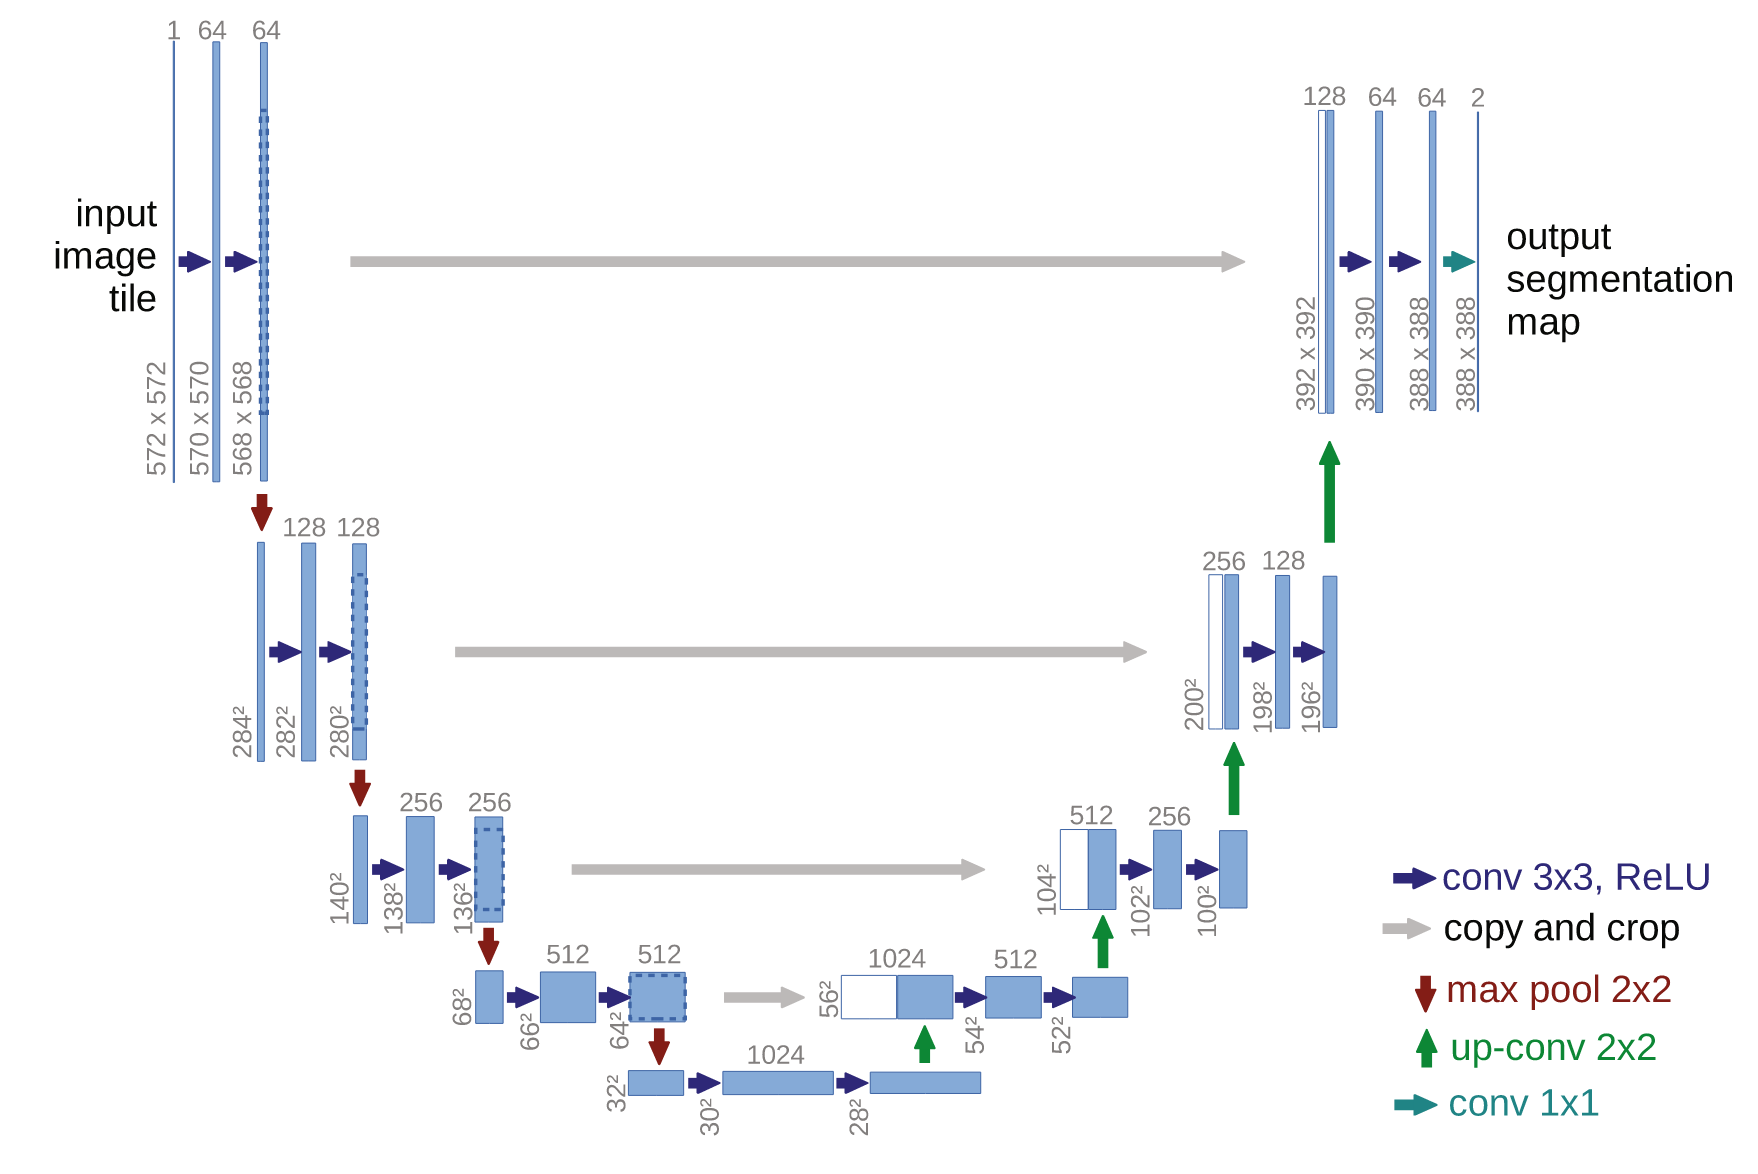

In [29]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    # 默认情况下是先做（双线性）上采样，然后再做卷积
    # 也可以是先做转置卷积，然后再做卷积

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            # 转置卷积！
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(
            x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2]
        )
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    """
    U-Net.

    Ronneberger, O., Fischer, P., & Brox, T. (2015). U-net: Convolutional networks for biomedical image segmentation. In Medical image computing and computer-assisted intervention–MICCAI 2015: 18th international conference, Munich, Germany, October 5-9, 2015, proceedings, part III 18 (pp. 234-241). Springer international publishing.
    """

    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

U-Net的输出和输入尺寸完全一致，这样设计是为了做语义分割任务：

In [30]:
u = UNet(1, 1)
x = torch.randn(1, 1, 256, 256)
u(x).shape, x.shape

(torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]))

### GAN

当然，GAN也是转置卷积的重要应用。GAN的目标是生成图像，转置卷积这种上采样算子就很适合了。

生成模型我了解不多，也不展开了。

## 注意力机制

下面一段由GPT生成，我进行了文献的检索、核查，总体还是非常靠谱的

> 注意力机制（Attention Mechanism） 是一种模仿人类视觉注意力的机制，它使得模型在处理信息时能够有选择性地关注输入中的关键部分，而不是平均地处理所有信息。它最初用于图像处理领域：《[A model of saliency-based visual attention for rapid scene analysis](https://ieeexplore.ieee.org/abstract/document/730558/)》，后来在自然语言处理（NLP）中取得了巨大成功，尤其是在序列到序列（seq2seq）模型中，比如机器翻译。
>
> 1. 早期背景：seq2seq 模型存在问题
>    - 论文：《[Sequence to Sequence Learning with Neural Networks](https://research.google/pubs/sequence-to-sequence-learning-with-neural-networks/)》
>    - 在 2014 年，Google 提出的Encoder-Decoder 架构（seq2seq模型）在机器翻译中表现优越。
>    - 问题：将整个输入序列压缩成一个固定向量，会丢失大量信息，尤其是长句子。
> 
> 2. 2014 - Bahdanau et al.（Additive Attention）
>    - 论文：《[Neural Machine Translation by Jointly Learning to Align and Translate](https://peerj.com/articles/cs-2607/code.zip)》
>    - 特点：引入注意力机制解决 seq2seq 编码瓶颈，通过对输入每个时间步计算一个相关性打分。
>    - 方法：使用一个前馈神经网络计算注意力得分（加性注意力）。
> 
> 3. 2015 - Luong el al.（Multiplicative Attention）
>    - 论文：《[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)》
>    - 特点：引入乘性注意力（dot-product 和 scaled dot-product），更计算高效。
> 
> 4. 2017 - Transformer
>    - 论文：《[Attention is All You Need](https://proceedings.neurips.cc/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html)》
>    - 创新：完全抛弃 RNN，全靠注意力机制（Self-Attention），并提出了多头注意力（Multi-Head Attention）。
>    - 特点：并行处理序列，高效捕捉全局依赖，开启了现代大型语言模型的时代（如 BERT、GPT）。
> 
> 5. 后续发展
>    - BERT（2018）：双向 Transformer 编码器，预训练语言理解。
>    - GPT 系列（2018）：基于 Transformer 解码器的生成式预训练模型。
>    - 视觉注意力（ViT, DETR 等）：将注意力机制应用于图像处理。
>    - Sparse Attention / Longformer / Performer：改进标准注意力在长序列上的效率问题。

本节的内容在[Sequence to Sequence (seq2seq) and Attention](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)这个博客讲的很好，图示也绝美。请务必去看看！

### Attention

Wiki上有一个动图，直观展示了Attention的出发点：

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Seq2seq_with_RNN_and_attention_mechanism.gif/500px-Seq2seq_with_RNN_and_attention_mechanism.gif)

我们无非是希望在Decoder中，尽量把**注意力**放在那些**更加相关**的变量上。

具体来说，在seq2seq模型中，模型由两个RNN构成:Encoder和Decoder。

Encoder把原始序列编码为数值向量：
$$
\vec H = (h_1,h_2,\cdots, h_n) = \mathrm{Enc}(\vec x)
$$
而后在Decoder的过程中，对于每一个$s_t$都计算注意力$\vec a$
$$
\vec a = (a(s_t, h_1),a(s_t, h_2),\cdots, a(s_t, h_n))
$$
其中$a$是某种计算，例如二次型($s^TWh$)、全连接神经网络($v^T(As+Bh+c)$)等（也就是我们最开始介绍的加性注意力和乘性注意力机制）。

接下来把softmax归一化的注意力引入到下一个状态的计算中：
$$
s_{t+1} = f(s_t, y_{t-1}, {\color{red} c_t})
$$
其中$c_t$称为context vector：
$$
c_t = \mathrm{softmax}(\vec a) \cdot \vec H
$$
最后得到最终结果：
$$
y = \mathrm{Dec}(\vec s) = \mathrm{Dec}(s_1,s_2,\cdots,s_t)
$$

上述计算过程可以看下图：

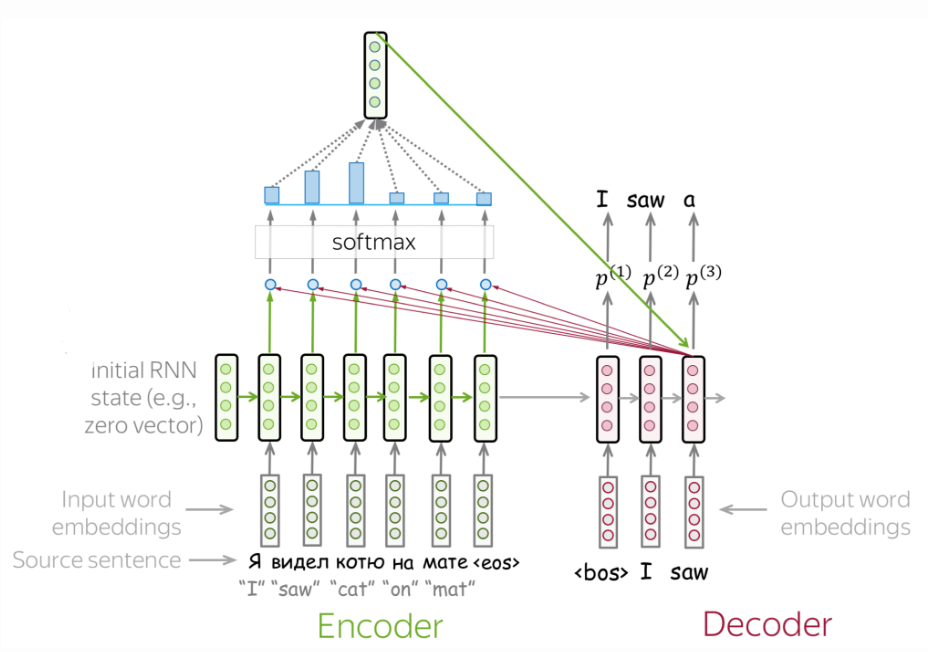

### Self-Attention

2017年，Transformer横空出世。注意力机制这么有用那我还要RNN干什么？于是他们打着Attention is all your need的旗号发布了Transformer。

想一下也不难理解，RNN的功能理论上完全可以由Self-Attention代替。一个典型的Encoder-Decoder RNN的计算过程是这样的：

$$
\vec x \to \vec h \to \vec s \to \vec y
$$

这里面RNN最重要的设计就是考虑滞后相关性：
$$
h_t = f(x_t, h_{t-1})
$$

如果使用自注意力机制，相当于$h_t$直接建模了全局相关性，是一种自回归：

$$
\vec h = \mathrm{SelfAttention}(\vec h)
$$

再加上广泛应用于seq2seq模型中的交叉注意力机制，我们就得到了Transformer：

- 左侧是Encoder，使用**自注意力机制**（self attention）建模相关性
- 右侧是Decoder，同样使用自注意力机制建模相关性
- 最终把Encoder和Decoder计算的自注意力得分使用**交叉注意力机制**（cross attention）融合
    - 把Encoder的注意力看作Query
    - 把Decoder的注意力看作Key和Value


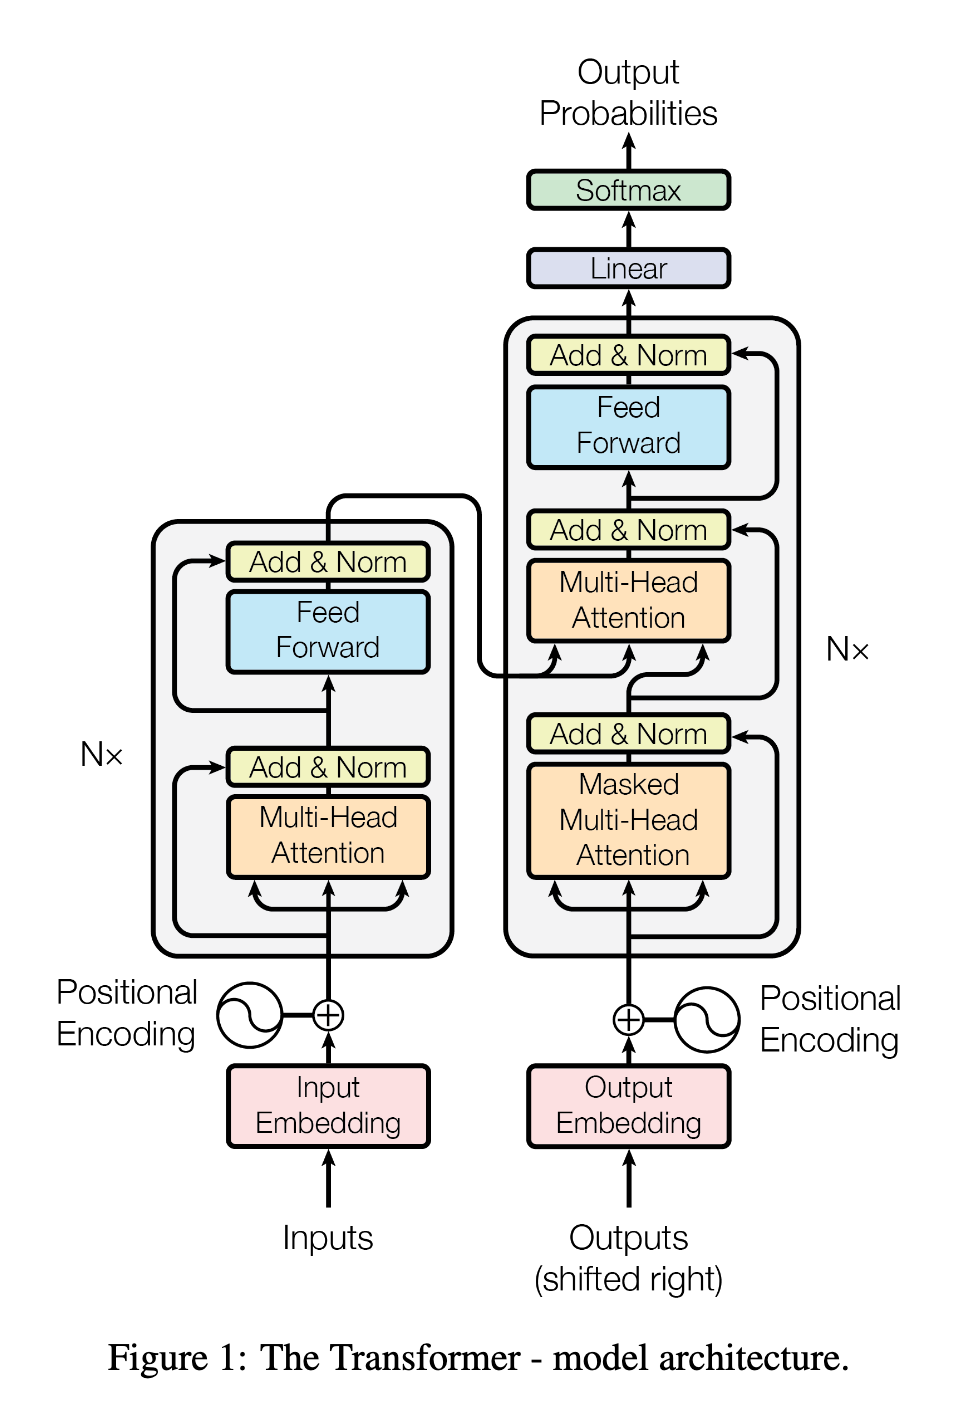

In [31]:
# 最简单的Transformer模型：
## 嵌入维度是26，头数是2，编码器和解码器各2层，前馈网络维度128，dropout概率为0
transformer = nn.Transformer(
    d_model=26,
    nhead=2,
    num_encoder_layers=1,
    num_decoder_layers=1,
    dim_feedforward=128,
    dropout=0,
    activation="relu",
    batch_first=False,
)
params = dict(transformer.named_parameters())
for name,p in params.items():
    print(name, p.shape, sep=', ')

encoder.layers.0.self_attn.in_proj_weight, torch.Size([78, 26])
encoder.layers.0.self_attn.in_proj_bias, torch.Size([78])
encoder.layers.0.self_attn.out_proj.weight, torch.Size([26, 26])
encoder.layers.0.self_attn.out_proj.bias, torch.Size([26])
encoder.layers.0.linear1.weight, torch.Size([128, 26])
encoder.layers.0.linear1.bias, torch.Size([128])
encoder.layers.0.linear2.weight, torch.Size([26, 128])
encoder.layers.0.linear2.bias, torch.Size([26])
encoder.layers.0.norm1.weight, torch.Size([26])
encoder.layers.0.norm1.bias, torch.Size([26])
encoder.layers.0.norm2.weight, torch.Size([26])
encoder.layers.0.norm2.bias, torch.Size([26])
encoder.norm.weight, torch.Size([26])
encoder.norm.bias, torch.Size([26])
decoder.layers.0.self_attn.in_proj_weight, torch.Size([78, 26])
decoder.layers.0.self_attn.in_proj_bias, torch.Size([78])
decoder.layers.0.self_attn.out_proj.weight, torch.Size([26, 26])
decoder.layers.0.self_attn.out_proj.bias, torch.Size([26])
decoder.layers.0.multihead_attn.in_proj

/opt/homebrew/Cellar/python@3.11/3.11.12/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


如此简单的Transformer参数也是一堆：

In [32]:
sum(p.numel() for p in transformer.parameters())

22408

居然有两万多个参数。恐怖如斯。


接下来我们依然是用这些参数复现Transformer的计算过程：

In [33]:
# (seq_len, batch_size, d_model)
src, tgt = torch.randn(10, 1, 26)*100, torch.randn(10, 1, 26)*100
torch_transformer_out = transformer(src, tgt)
torch_transformer_out.shape

torch.Size([10, 1, 26])

### 手撕Transformer

我们输入的src和tgt都是`(10,1,26)`维度的，代表一句话，10个词，每个词用26维度的向量来表示。

首先我们考虑src进入Encoder的计算。



In [34]:
# 为了方便复现，我们设置drop概率为0
drop = nn.Dropout(0)

#### Encoder层

In [35]:
# 编码层自注意力
## QVK一起计算
encoder_projection = (
    src @ params["encoder.layers.0.self_attn.in_proj_weight"].T
    + params["encoder.layers.0.self_attn.in_proj_bias"]
)
## 分离计算QKV
q, k, v = encoder_projection.split(26, dim=-1)
## 需要转置为 (1,2,10,13) 也就是 (batch, head, seq_len, d_model/num_heads)
## 从而在后续的矩阵乘法，把13消掉
q = q.view(10, 1, 2, 13).permute(1, 2, 0, 3)
k = k.view(10, 1, 2, 13).permute(1, 2, 0, 3)
v = v.view(10, 1, 2, 13).permute(1, 2, 0, 3)
## 计算注意力分数，这是一个(seq_len, seq_len)的矩阵
## 因为我们这里计算的是 ** 一个句子内部，不同词之间的相关性 **
score = torch.softmax(q @ k.transpose(-1, -2) / (13**0.5), dim=-1)
## 计算注意力值
attention = score @ v
attention_out = (
    attention.transpose(1, 2).contiguous().view(10, 1, 26)
    @ params["encoder.layers.0.self_attn.out_proj.weight"].T
    + params["encoder.layers.0.self_attn.out_proj.bias"]
)
attention_out = drop(attention_out)
# add & norm
self_attention = torch.nn.functional.layer_norm(
    src + attention_out,
    [26],
    weight=params["encoder.layers.0.norm1.weight"],
    bias=params["encoder.layers.0.norm1.bias"],
)
# FFN
ffn_out = torch.relu(
    self_attention @ params["encoder.layers.0.linear1.weight"].T
    + params["encoder.layers.0.linear1.bias"]
)
ffn_out = drop(ffn_out)
ffn_out = (
    ffn_out @ params["encoder.layers.0.linear2.weight"].T
    + params["encoder.layers.0.linear2.bias"]
)
ffn_out = drop(ffn_out)
# add & norm
encoder_out = torch.nn.functional.layer_norm(
    self_attention + ffn_out,
    [26],
    weight=params["encoder.layers.0.norm2.weight"],
    bias=params["encoder.layers.0.norm2.bias"],
)
encoder_out = torch.nn.functional.layer_norm(
    encoder_out,
    [26],
    weight=params["encoder.norm.weight"],
    bias=params["encoder.norm.bias"],
)

In [36]:
# 我们手动复现的encoder和torch的encoder输出是一样的，好诶！😊
encoder_out[-1],transformer.encoder(src)[-1]

(tensor([[ 0.3903,  1.4148, -0.1740,  0.9718,  0.1106, -1.8590, -0.0811,  0.2278,
           0.2675,  0.9090,  0.0911,  2.1870, -1.0538, -0.4497, -0.3166,  0.5548,
          -1.3327,  1.1305, -1.5947, -0.9230,  0.4612,  1.1480, -1.4240,  0.8699,
          -0.7066, -0.8192]], grad_fn=<SelectBackward0>),
 tensor([[ 0.3903,  1.4148, -0.1740,  0.9718,  0.1106, -1.8590, -0.0811,  0.2278,
           0.2675,  0.9090,  0.0911,  2.1870, -1.0538, -0.4497, -0.3166,  0.5548,
          -1.3327,  1.1305, -1.5947, -0.9230,  0.4612,  1.1480, -1.4240,  0.8699,
          -0.7066, -0.8192]], grad_fn=<SelectBackward0>))

In [37]:
torch.allclose(encoder_out,transformer.encoder(src), atol=1e-6)

True

#### Decoder层

In [38]:
# 解码层自注意力
## 和编码层自注意力完全一致，把输入替换为tgt即可
decoder_projection = (
    tgt @ params["decoder.layers.0.self_attn.in_proj_weight"].T
    + params["decoder.layers.0.self_attn.in_proj_bias"]
)
q, k, v = decoder_projection.split(26, dim=-1)
q = q.view(10, 1, 2, 13).permute(1, 2, 0, 3)
k = k.view(10, 1, 2, 13).permute(1, 2, 0, 3)
v = v.view(10, 1, 2, 13).permute(1, 2, 0, 3)
score = q @ k.transpose(-1, -2) / (13**0.5)
mask = torch.tril(torch.ones(1, 2, 10, 10))
score = score.masked_fill(mask == 0, -1e9)
score = torch.softmax(score, dim=-1)
attention = score @ v
out = (
    attention.transpose(1, 2).contiguous().view(10, 1, 26)
    @ params["decoder.layers.0.self_attn.out_proj.weight"].T
    + params["decoder.layers.0.self_attn.out_proj.bias"]
)
out = drop(out)
tgt_attention = torch.nn.functional.layer_norm(
    tgt + out,
    [26],
    weight=params["decoder.layers.0.norm1.weight"],
    bias=params["decoder.layers.0.norm1.bias"],
)

# 交叉注意力（cross attention）
wq, wk, wv = params["decoder.layers.0.multihead_attn.in_proj_weight"].split(26, dim=0)
bq, bk, bv = params["decoder.layers.0.multihead_attn.in_proj_bias"].split(26, dim=0)
proj_Q = tgt_attention @ wq.T + bq
proj_K = encoder_out @ wk.T + bk
proj_V = encoder_out @ wv.T + bv
q = proj_Q.view(10, 1, 2, 13).permute(1, 2, 0, 3)
k = proj_K.view(10, 1, 2, 13).permute(1, 2, 0, 3)
v = proj_V.view(10, 1, 2, 13).permute(1, 2, 0, 3)
score = torch.softmax(q @ k.transpose(-1, -2) / (13**0.5), dim=-1)
attention = score @ v
out = (
    attention.transpose(1, 2).contiguous().view(10, 1, 26)
    @ params["decoder.layers.0.multihead_attn.out_proj.weight"].T
    + params["decoder.layers.0.multihead_attn.out_proj.bias"]
)
out = drop(out)
# add & norm
cross_attention = torch.nn.functional.layer_norm(
    tgt_attention + out,
    [26],
    weight=params["decoder.layers.0.norm2.weight"],
    bias=params["decoder.layers.0.norm2.bias"],
)
# FFN
ffn_out = torch.relu(
    cross_attention @ params["decoder.layers.0.linear1.weight"].T
    + params["decoder.layers.0.linear1.bias"]
)
ffn_out = drop(ffn_out)
ffn_out = (
    ffn_out @ params["decoder.layers.0.linear2.weight"].T
    + params["decoder.layers.0.linear2.bias"]
)
ffn_out = drop(ffn_out)
# add & norm
decoder_out = torch.nn.functional.layer_norm(
    cross_attention + ffn_out,
    [26],
    weight=params["decoder.layers.0.norm3.weight"],
    bias=params["decoder.layers.0.norm3.bias"],
)
decoder_out = torch.nn.functional.layer_norm(
    decoder_out,
    [26],
    weight=params["decoder.norm.weight"],
    bias=params["decoder.norm.bias"],
)

In [39]:
# 再一次，我们复现的decoder和torch的decoder输出是一样的，好诶！😊
decoder_out[-1], transformer(src, tgt)[-1]

(tensor([[ 1.0666,  1.9875, -0.2308, -0.2756,  0.3134,  0.1232,  0.4551, -1.9673,
           1.3069, -0.9641,  1.0270,  0.5868, -2.2682, -1.2953,  1.5865, -0.1992,
           0.0951, -0.2316, -0.3105, -0.9452, -0.9148,  0.6743, -0.0223,  0.5336,
          -0.5845,  0.4533]], grad_fn=<SelectBackward0>),
 tensor([[ 1.0666,  1.9875, -0.2308, -0.2756,  0.3134,  0.1232,  0.4551, -1.9673,
           1.3069, -0.9641,  1.0270,  0.5868, -2.2682, -1.2953,  1.5865, -0.1992,
           0.0951, -0.2316, -0.3105, -0.9452, -0.9148,  0.6743, -0.0223,  0.5336,
          -0.5845,  0.4533]], grad_fn=<SelectBackward0>))

### DecoderOnly

 Transformer之后，很快就出现了大量跟进的工作。

 其中出现了以GPT为代表的DecoderOnly架构。

 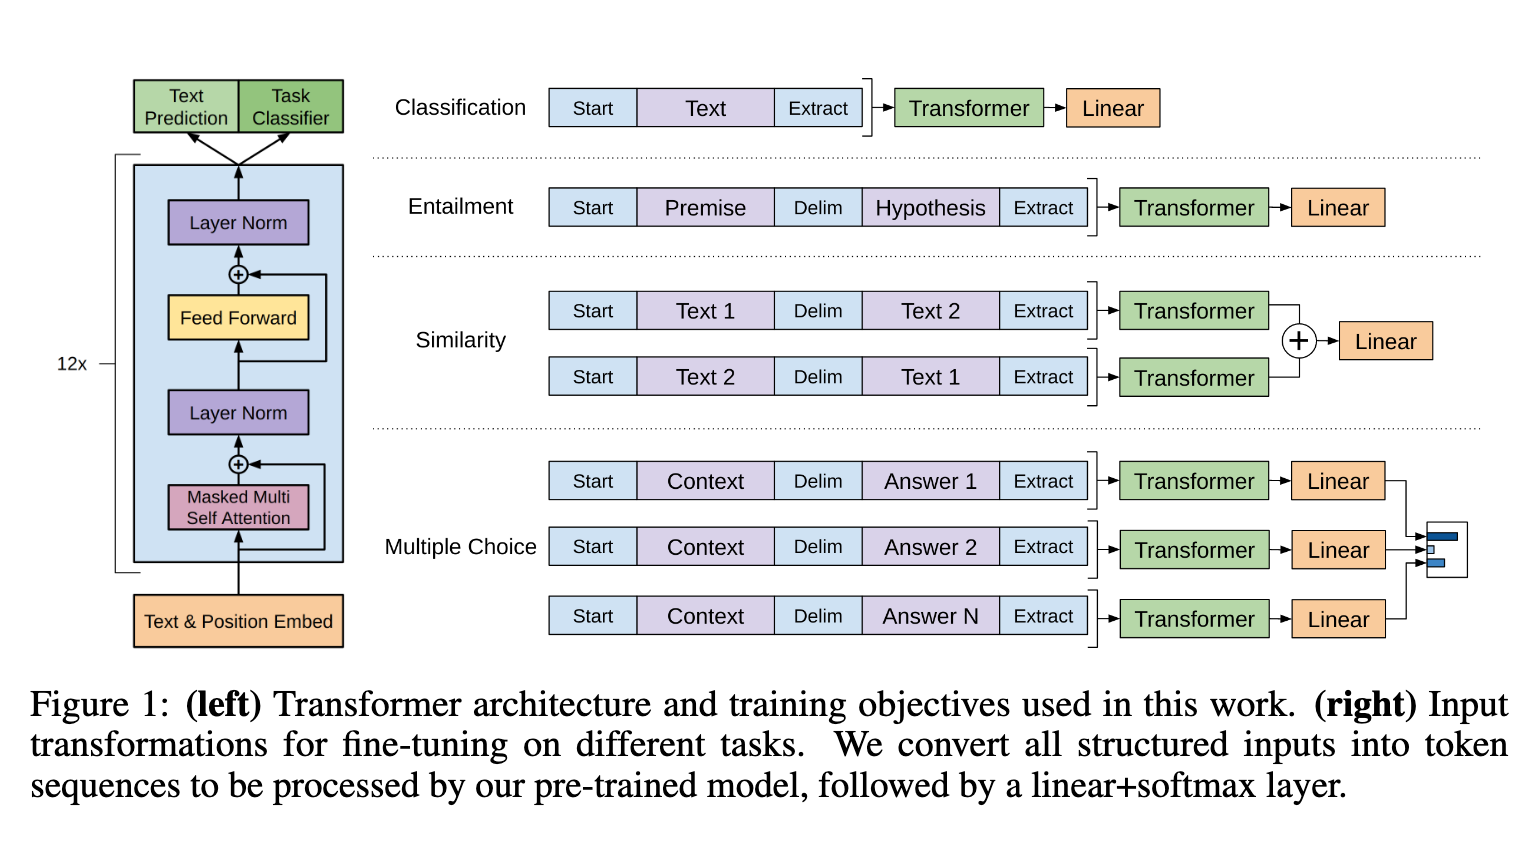

### EncoderOnly

当然也出现了以BERT为代表的EncoderOnly的架构。

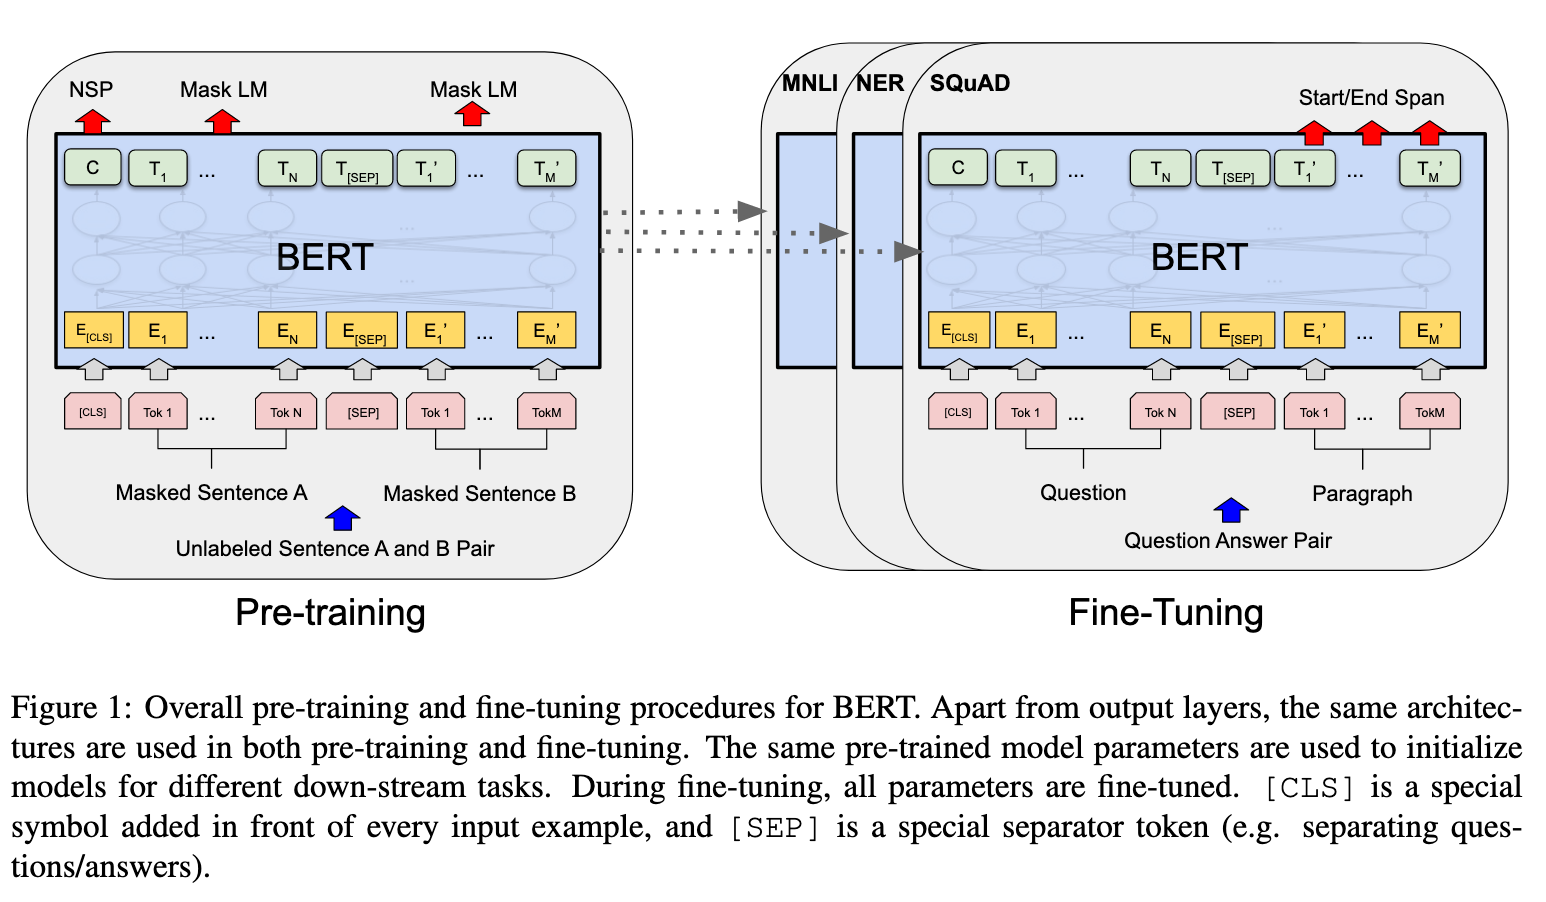

## 其他神经网络

### 图神经网络
> Graph Neural Networks

图神经网络比较特殊。我也是刚了解，大家感兴趣可以去看看：[A Gentle Introduction to Graph Neural Networks](https://distill.pub/2021/gnn-intro/)和[Understanding Convolutions on Graphs](https://distill.pub/2021/understanding-gnns/)，分别介绍了GNN和GCN。我这里也不再展开了。

本质上图神经网络只是把神经网络应用到了图结构的数据上，并非一种全新的网络结构。

### 脉冲神经网络
> Spike Neural Networks

一种模拟神经电脉冲的新型网络范式。

### 随机神经网络

> Stochastic Neural Networks

它们向神经网络引进随机变化，一类是在神经元之间分配随机过程传递函数，一类是给神经元随机权重。这使得随机神经网络在优化（Optimization）问题中非常有用，因为随机的变换避免了局部最优（local minima）。

由随机传递函数建立的随机神经网络通常被称为波茨曼机（Boltzmann machine）。在此基础上还有受限玻尔兹曼机（Restricted Boltzmann Machine）和深度信念网络（Deep Belief Network）

随机神经网络在风险控制，肿瘤学和生物信息学相关领域均有应用。